# 고객 데이터를 활용한 상품 배송 분석

## 데이터 확인
피쳐 컬럼 리스트  
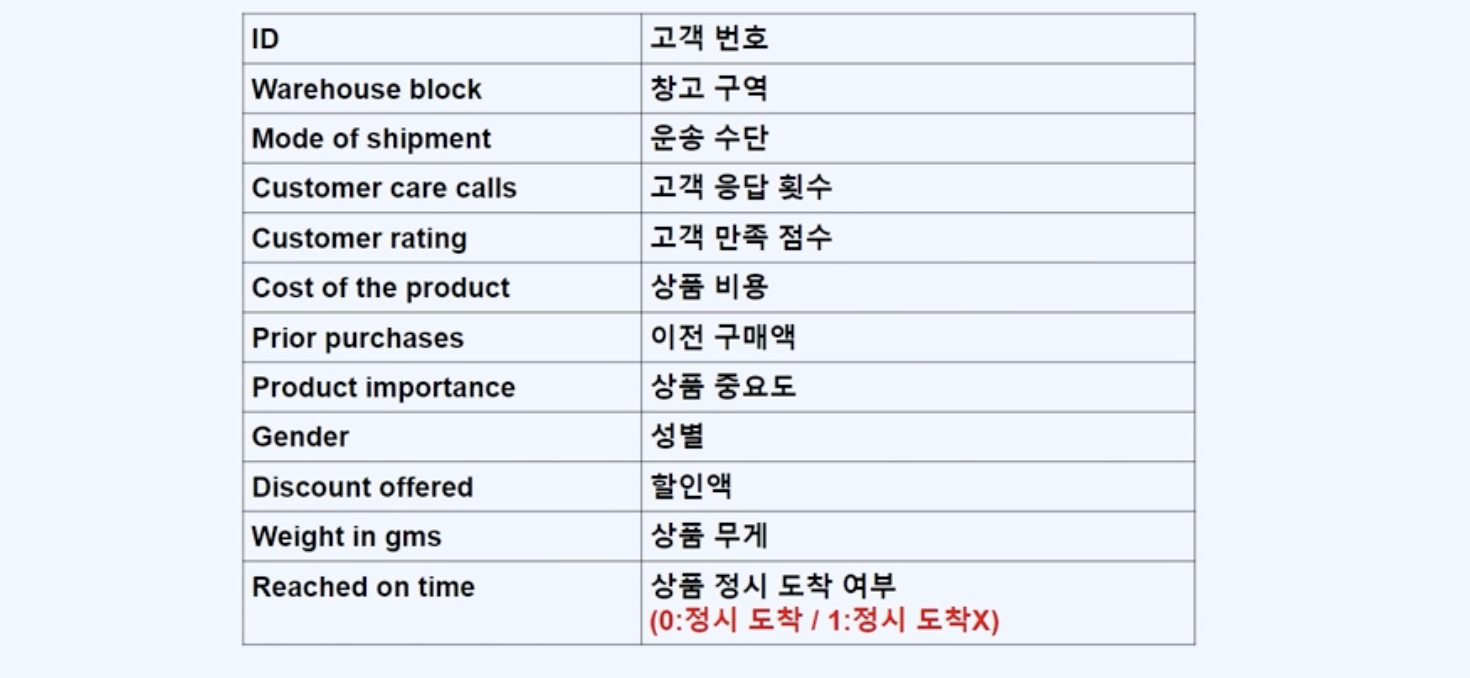

Reached on time 항목을 target 값으로 활용 가능

**분석 목표: 고객 상품 배송 정보를 활용한 정시 배송 예측**  

<진행 내용>  
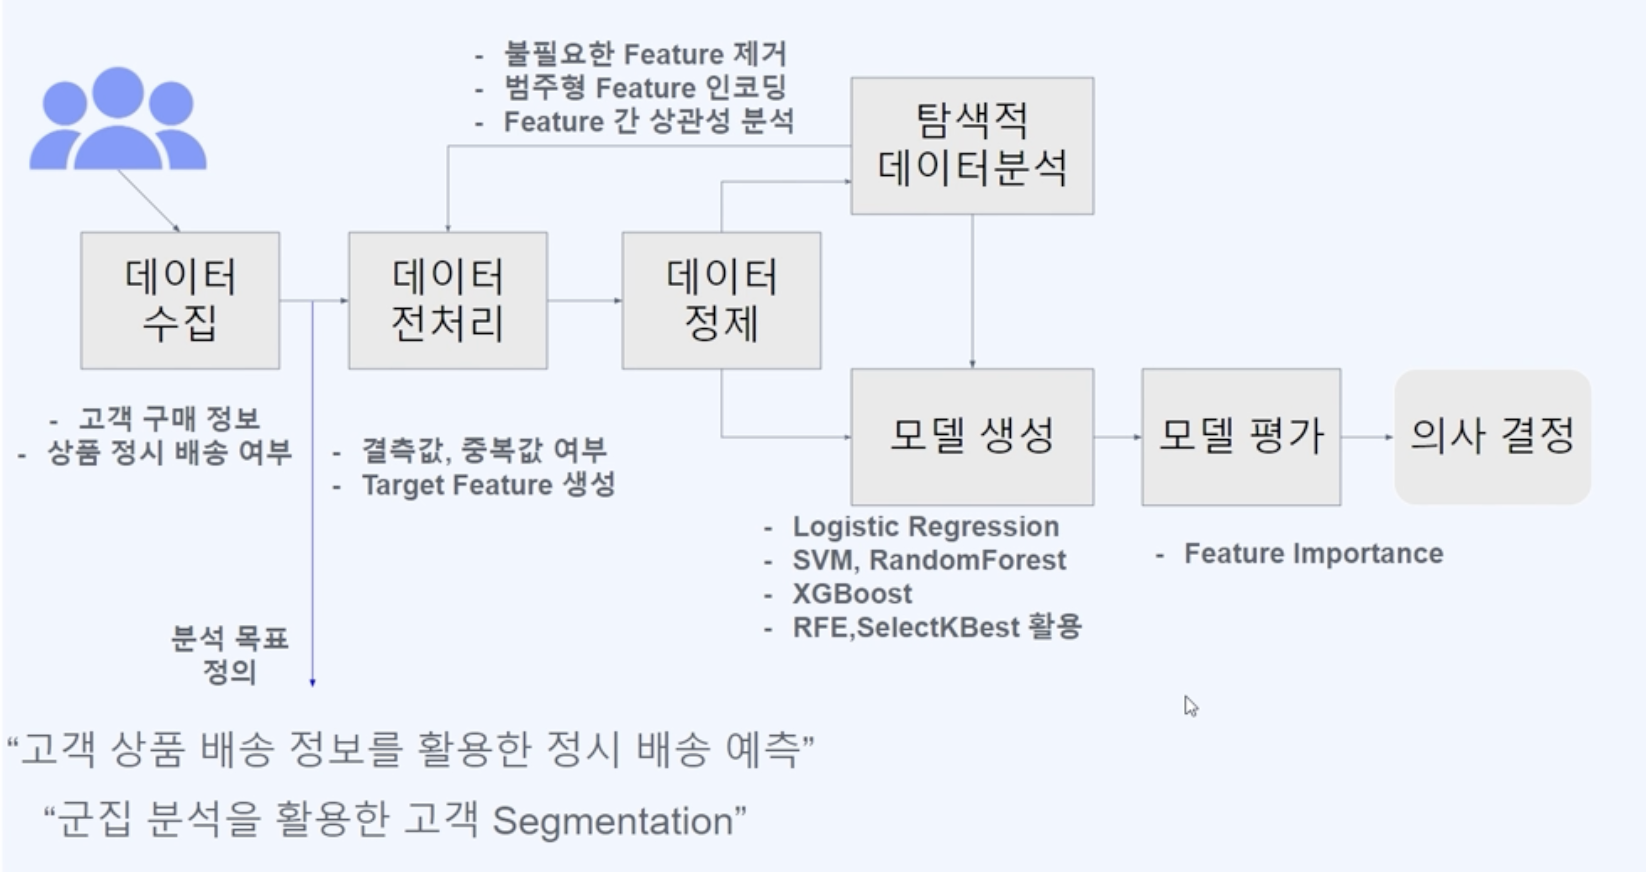

> matplotlib 한글 깨짐 현상 해결을 위해 아래 셀 실행 후 런타임 재시작 필요

In [1]:
! apt-get update -qq
! apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = 'NanumGothic'
fe = fm.FontEntry(fname=path, name=font_name)
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': font_name})

Selecting previously unselected package fonts-nanum.
(Reading database ... 120880 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


## 데이터 탐색 및 전처리

### 데이터 불러오기

In [2]:
# 필요 파이썬 라이브러리 불러오기

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.decomposition import PCA

import scipy.cluster.hierarchy as shc

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations

# import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/05_item_delivery_analyzing_using_customer_data/Train.csv')
train.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [5]:
# 데이터의 모양 알아보기
train.shape

(10999, 12)

### 데이터 탐색

1) 데이터 타입

In [6]:
# 컬럼별 데이터 타입 알아보기
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


2) 데이터 통계값

In [7]:
# 컬럼별 간단한 통계값 보기
train.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


3) 변수간 관계 그래프

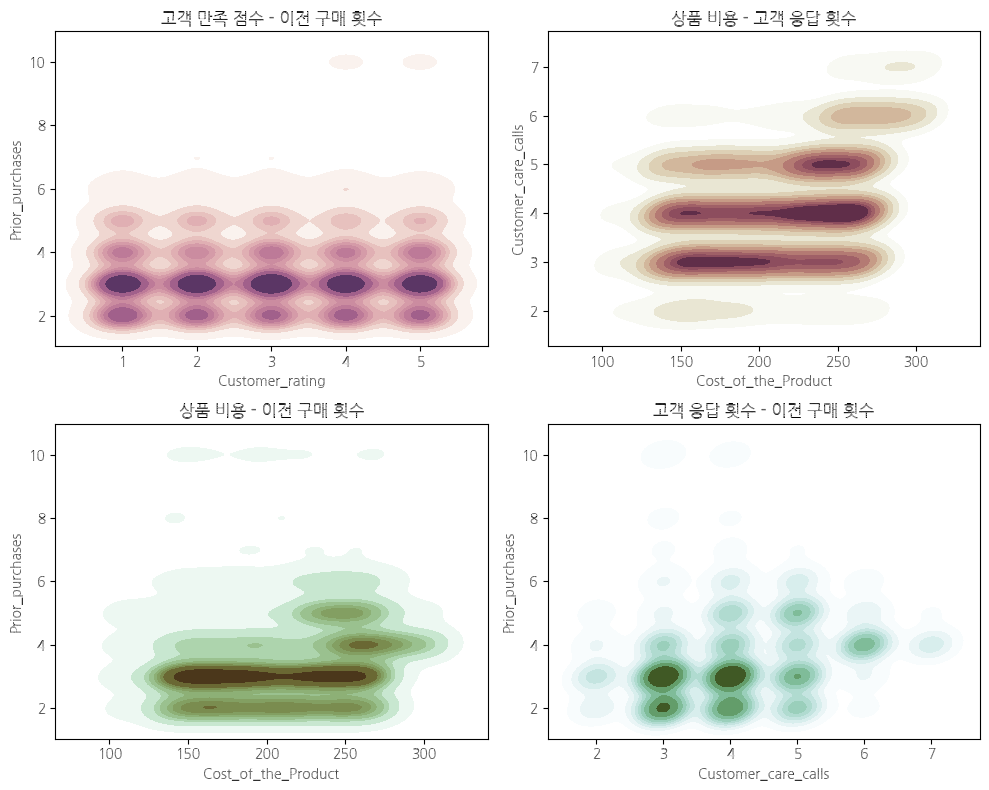

In [8]:
# 여러 개의 KDE Plot 생성 준비
f, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=False, sharey=False)

# Plot 색상 설정
s = np.linspace(0, 3, 10)

# 1-1
cmap = sns.cubehelix_palette(start=0.0, light=1, as_cmap=True)
x = train['Customer_rating']
y = train['Prior_purchases']
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[0, 0])
axes[0, 0].set(title='고객 만족 점수 - 이전 구매 횟수')

# 1-2
cmap = sns.cubehelix_palette(start=0.333, light=1, as_cmap=True)
x = train['Cost_of_the_Product']
y = train['Customer_care_calls']
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[0, 1])
axes[0, 1].set(title='상품 비용 - 고객 응답 횟수')

# 2-1
cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)
x = train['Cost_of_the_Product']
y = train['Prior_purchases']
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[1, 0])
axes[1, 0].set(title='상품 비용 - 이전 구매 횟수')

# 2-2
cmap = sns.cubehelix_palette(start=1.333, light=1, as_cmap=True)
x = train['Customer_care_calls']
y = train['Prior_purchases']
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[1, 1])
axes[1, 1].set(title='고객 응답 횟수 - 이전 구매 횟수')

f.tight_layout()

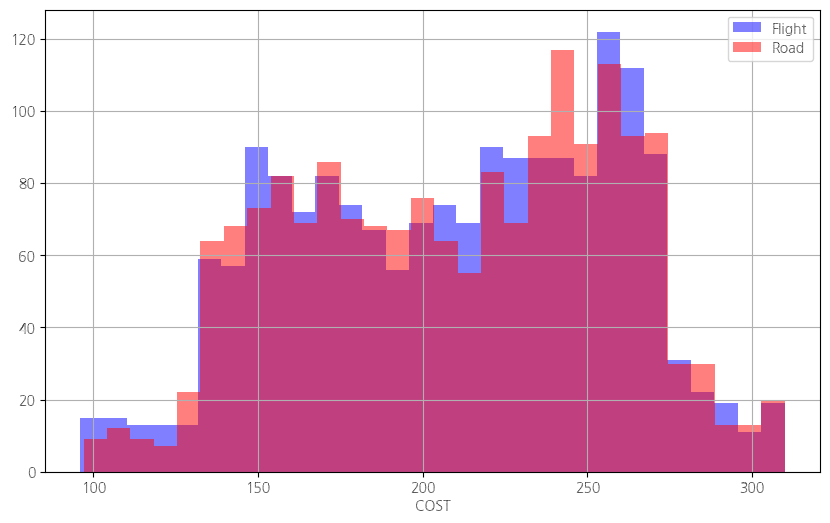

In [9]:
plt.figure(figsize=(10, 6))
train[train['Mode_of_Shipment']=='Flight']['Cost_of_the_Product'].hist(alpha=0.5, color='blue', bins=30, label='Flight')
train[train['Mode_of_Shipment']=='Road']['Cost_of_the_Product'].hist(alpha=0.5, color='red', bins=30, label='Road')
plt.xlabel('COST')
plt.legend()

4) 결측값

In [10]:
train.isnull().any()

ID                     False
Warehouse_block        False
Mode_of_Shipment       False
Customer_care_calls    False
Customer_rating        False
Cost_of_the_Product    False
Prior_purchases        False
Product_importance     False
Gender                 False
Discount_offered       False
Weight_in_gms          False
Reached.on.Time_Y.N    False
dtype: bool

5) 중복값

In [11]:
# 중복된 항목 수 알아보기
print("중복된 항목 수: ", len(train[train.duplicated()]))

중복된 항목 수:  0


### 데이터 전처리

#### 1) 데이터 컬럼명 수정

In [12]:
train = train.rename(columns={"Reached.on.Time_Y.N": "Reached_on_Time_Y_N"})

#### 2) Target Feature 정의
1) 데이터 탐색
  > `Reached_on_Time_Y_N`이 0인 경우 제 시간 내에 배송이 된 것

In [13]:
train.groupby('Reached_on_Time_Y_N').mean()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
Reached_on_Time_Y_N,,,,,,,
0,7090.479486,4.147656,2.967989,214.498647,3.670424,5.545987,4168.668395
1,4424.978364,3.991467,3.005790,207.289197,3.498095,18.663721,3272.640104


In [14]:
train.groupby('Reached_on_Time_Y_N').median()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
Reached_on_Time_Y_N,,,,,,,
0,7096.0,4.0,3.0,222.0,3.0,6.0,4674.0
1,3467.0,4.0,3.0,209.0,3.0,9.0,3231.0


In [15]:
y = train['Reached_on_Time_Y_N'].copy()
y.value_counts()

1    6563
0    4436
Name: Reached_on_Time_Y_N, dtype: int64

2) 숫자형 변수들과의 관계

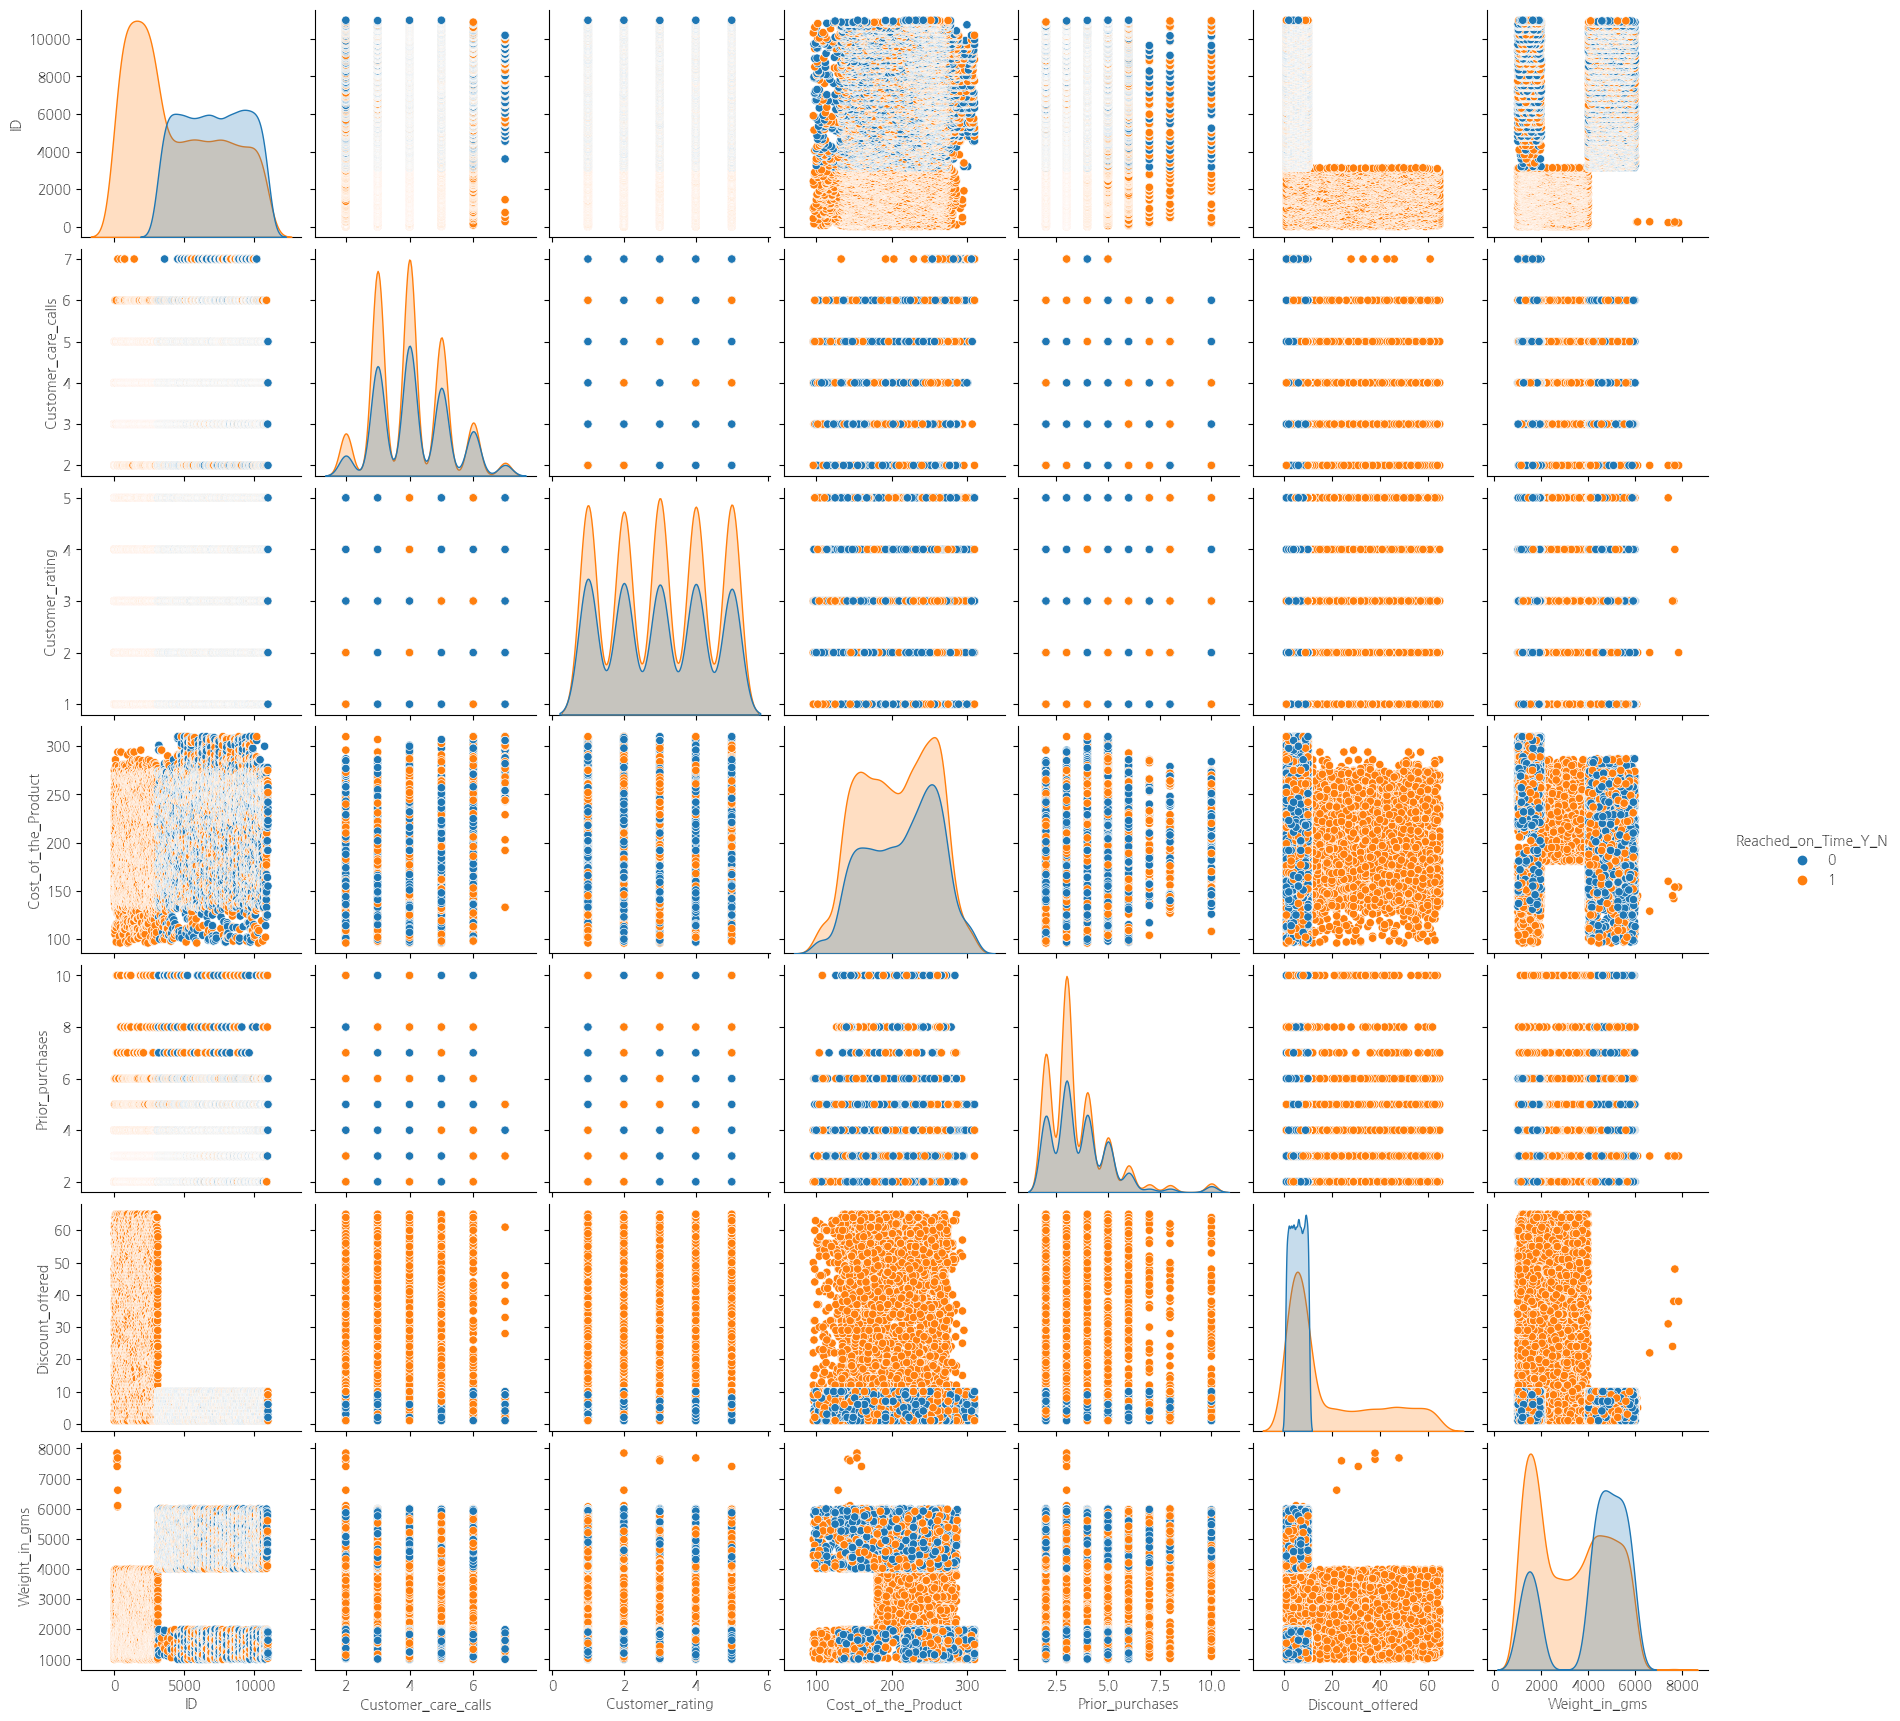

In [16]:
hue = 'Reached_on_Time_Y_N'
sns.pairplot(train.select_dtypes(include=np.number), hue=hue)
plt.show()

3) 각 변수별 Target Feature 그래프  
> 이전 구매 횟수 별 Target Feature

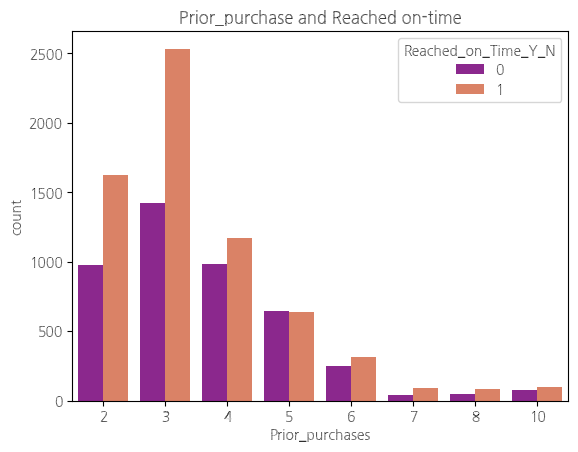

In [17]:
sns.countplot(x='Prior_purchases', data=train, palette="plasma", hue="Reached_on_Time_Y_N")
plt.title('Prior_purchase and Reached on-time')
plt.show()

> 고객 평가 점수별 Target Feature

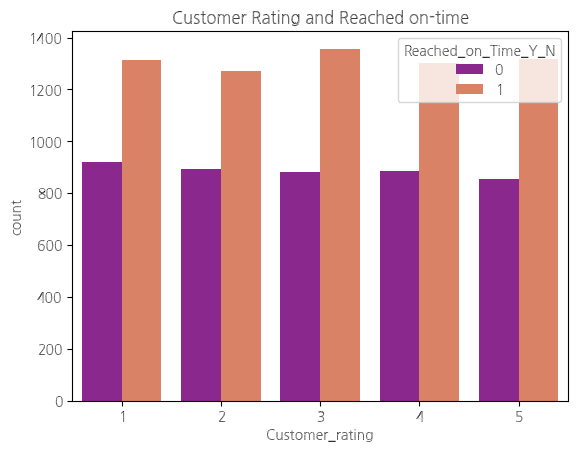

In [18]:
sns.countplot(x='Customer_rating', data=train, palette='plasma', hue='Reached_on_Time_Y_N')
plt.title('Customer Rating and Reached on-time')
plt.show()

> 상품 중요도별 Target Feature

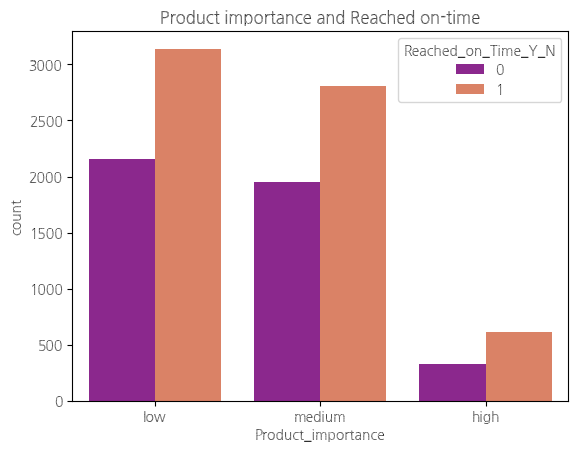

In [19]:
sns.countplot(x='Product_importance', data=train, palette='plasma', hue='Reached_on_Time_Y_N')
plt.title('Product importance and Reached on-time')
plt.show()

> 성별에 따른 Target Feature

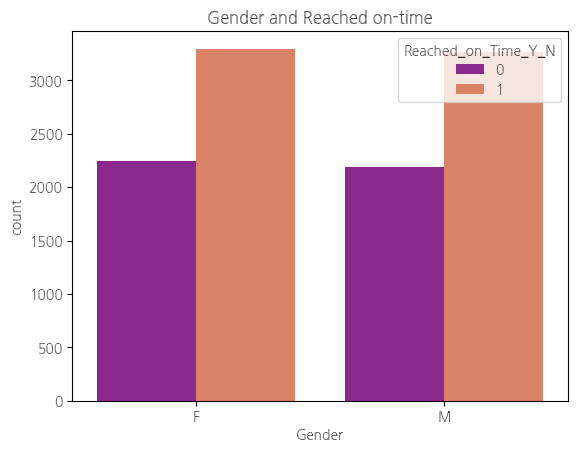

In [20]:
sns.countplot(x='Gender', data=train, palette='plasma', hue='Reached_on_Time_Y_N')
plt.title('Gender and Reached on-time')
plt.show()

> 창고 구역별 Target Feature

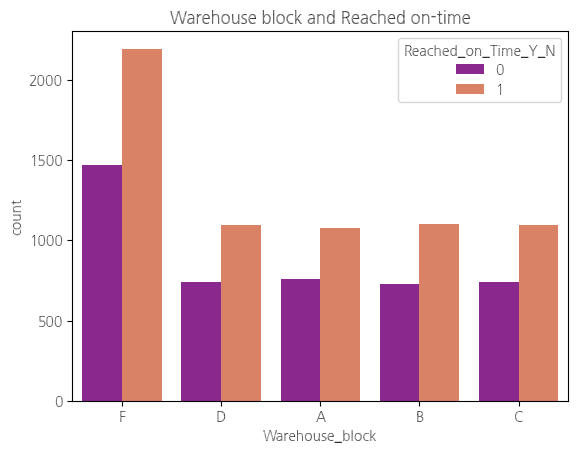

In [21]:
sns.countplot(x='Warehouse_block', data=train, palette='plasma', hue='Reached_on_Time_Y_N', order=train['Warehouse_block'].value_counts().index)
plt.title('Warehouse block and Reached on-time')
plt.show()

> 운송 수단별 Target Feature

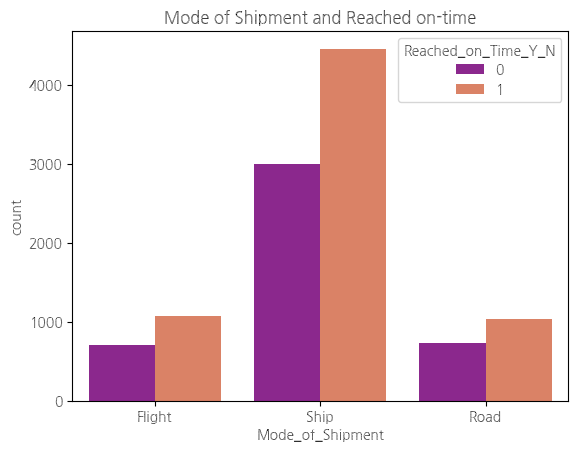

In [22]:
sns.countplot(x='Mode_of_Shipment', data=train, palette='plasma', hue='Reached_on_Time_Y_N')
plt.title('Mode of Shipment and Reached on-time')
plt.show()

> 고객 응답 횟수별 Target Feature

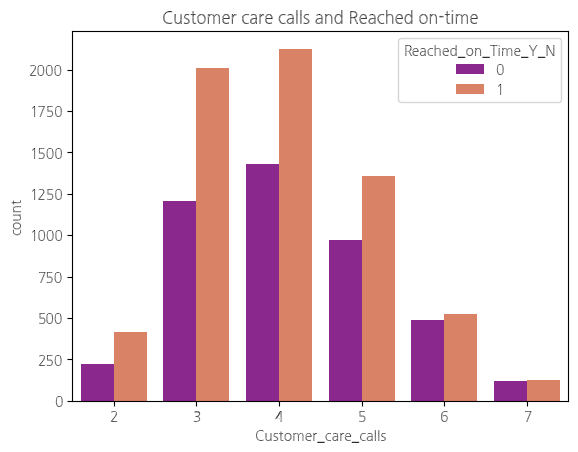

In [23]:
sns.countplot(x='Customer_care_calls', data=train, palette='plasma', hue='Reached_on_Time_Y_N')
plt.title('Customer care calls and Reached on-time')
plt.show()

#### 3) 데이터 타입별 Feature 변환

1) Feature 탐색  
- 총 Feature 개수 확인

In [24]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached_on_Time_Y_N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB
None


- Feature 데이터 타입별 개수 확인

In [25]:
# 데이터 타입별 컬럼 수 확인
dtype_data = train.dtypes.reset_index()
dtype_data.columns = ["Count", "Column Type"]

dtype_data = dtype_data.groupby("Column Type").aggregate('count').reset_index()

print(dtype_data)

  Column Type  Count
0       int64      8
1      object      4


2) 범주형 Feature
- 데이터 확인
- Feature 별 개수 시각화
- 날짜/숫자/기간 등으로 변환해야 할 항목이 있는지 확인
- Feature의 개수가 인코딩에 적합한가?

> 데이터 확인

In [26]:
train.select_dtypes(include=['object', 'category']).head()

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
0,D,Flight,low,F
1,F,Flight,low,M
2,A,Flight,low,M
3,B,Flight,medium,M
4,C,Flight,medium,F


> Feature 제거
> - Feature별 유일한 값 개수 확인
> - 유일한 값이 1개인 경우 또는 모든 행의 값이 다른 경우는 제거
> - Target Feature가 포함되어 있으면 함께 제거

In [27]:
cat_feat = train.select_dtypes('object', 'category').columns.values
train_cat = train[cat_feat].copy()
print(train_cat.nunique().sort_values())

Gender                2
Mode_of_Shipment      3
Product_importance    3
Warehouse_block       5
dtype: int64


> Feature 별 개수 시각화

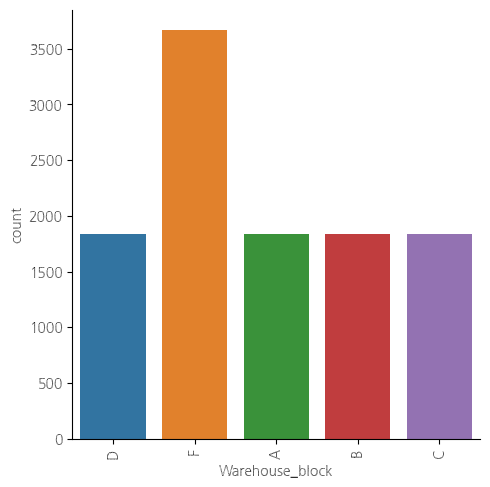

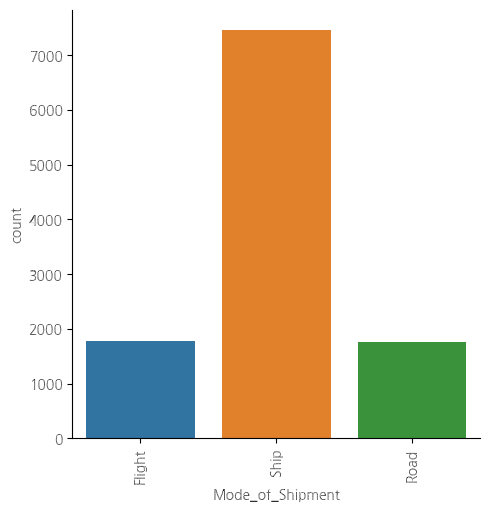

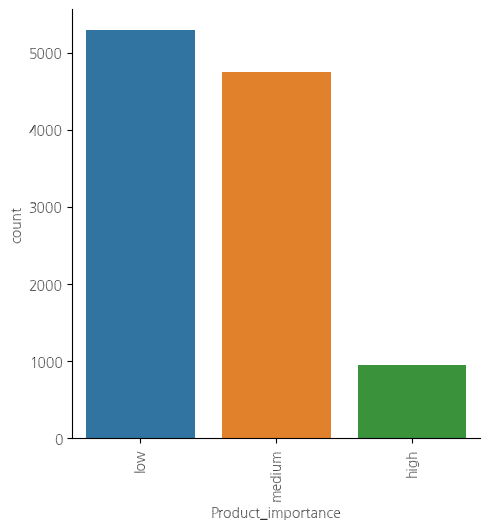

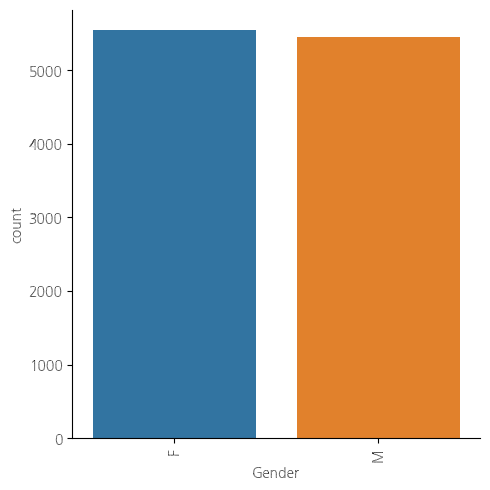

In [28]:
for col in train_cat.columns:
  fig = sns.catplot(x=col, kind="count", data=train_cat, hue=None)
  fig.set_xticklabels(rotation=90)
  plt.show()

Feature의 개수가 인코딩에 적합한가?
- 인코딩을 했을 경우 메모리 문제가 발생하지는 않는가?

> Feature 인코딩
> - LabelEncoder: LabelEncoder는 선형성을 가지는 머신러닝 기법에 쓰면 좋지 않음  
> - OneHotEncoder vs get_dummies

In [29]:
train_cat_dummies = pd.get_dummies(train_cat)
train_cat_dummies.head()

,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
0,0,0,0,1,0,1,0,0,0,1,0,1,0
1,0,0,0,0,1,1,0,0,0,1,0,0,1
2,1,0,0,0,0,1,0,0,0,1,0,0,1
3,0,1,0,0,0,1,0,0,0,0,1,0,1
4,0,0,1,0,0,1,0,0,0,0,1,1,0


3) 숫자형 Feature
- 데이터 확인
- Feature 제거
- Feature Skewness 확인

> 데이터 확인

In [30]:
train.select_dtypes(include=['number']).head()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached_on_Time_Y_N
0,1,4,2,177,3,44,1233,1
1,2,4,5,216,2,59,3088,1
2,3,2,2,183,4,48,3374,1
3,4,3,3,176,4,10,1177,1
4,5,2,2,184,3,46,2484,1


In [31]:
train.select_dtypes(include=np.number).head()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached_on_Time_Y_N
0,1,4,2,177,3,44,1233,1
1,2,4,5,216,2,59,3088,1
2,3,2,2,183,4,48,3374,1
3,4,3,3,176,4,10,1177,1
4,5,2,2,184,3,46,2484,1


In [32]:
num_feat = train.select_dtypes('number').columns.values
train_num = train[num_feat].copy()

> Feature 제거
> - Feature별 유일한 값 개수 확인

In [33]:
train_num.nunique().sort_values()

Reached_on_Time_Y_N        2
Customer_rating            5
Customer_care_calls        6
Prior_purchases            8
Discount_offered          65
Cost_of_the_Product      215
Weight_in_gms           4034
ID                     10999
dtype: int64

> 유일한 값이 1개인 경우 또는 모든 행의 값이 다른 경우는 제거  
> - Target Featurer가 포함되어 있으면 함께 제거

In [34]:
train_num = train_num.drop(columns=["ID", "Reached_on_Time_Y_N"], axis=1, errors='ignore')

> Feature Skewness 확인

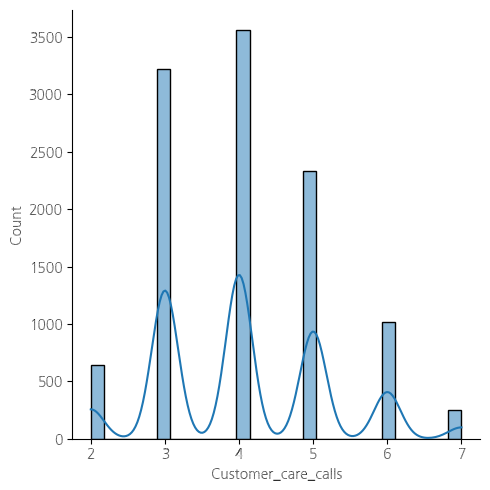

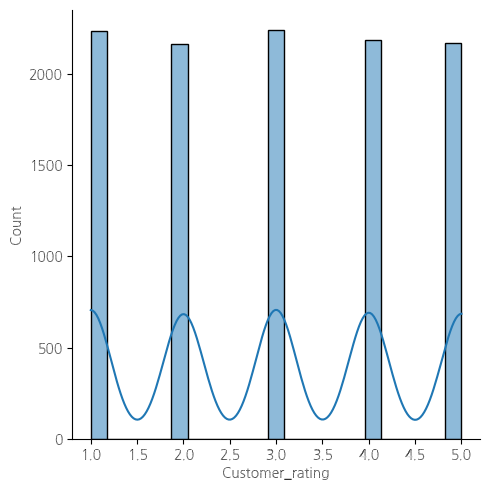

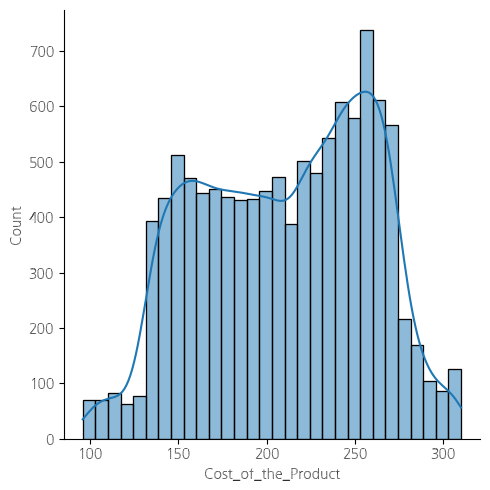

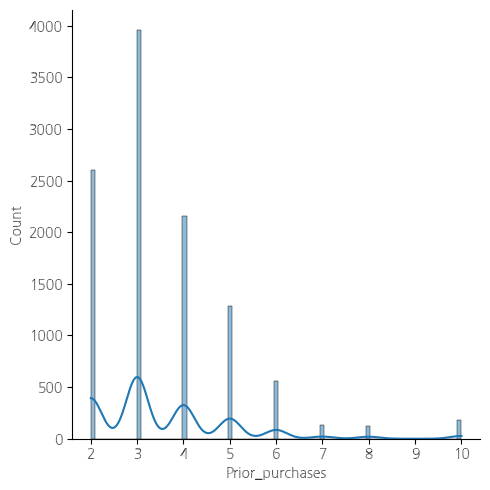

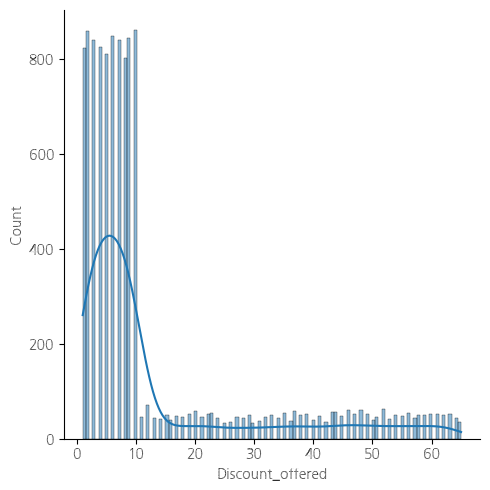

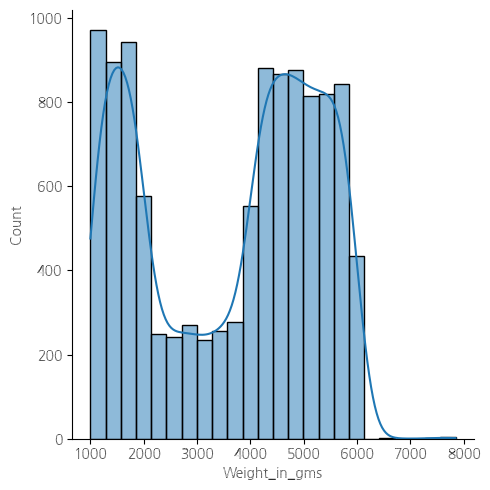

In [35]:
col_attrition_num = train_num.columns.values
for i in range(0, len(col_attrition_num)):
  sns.displot(train_num[col_attrition_num[i]], kde=True)

#### 4) 상관성에 따른 Feature 정제

1) 숫자형 Feature
- 데이터 확인
- 숫자형 컬럼들 간 Pearson R 상관계수 구하기
- 상관계수가 0.9 이상인 컬럼들 중 가장 큰 컬럼 제거  
- 컬럼들 간 조합 생성: `comb_num_feat = np.array(list(combinations(num_feat, 2)))`
- Pearson R 상관계수 구하기: `pearsonr(x1, x2)[0]`

> 데이터 확인

In [36]:
train_num.nunique().sort_values()

Customer_rating           5
Customer_care_calls       6
Prior_purchases           8
Discount_offered         65
Cost_of_the_Product     215
Weight_in_gms          4034
dtype: int64

> 상관 계수 구하기  
> - 방법 1

In [37]:
num_feat = train_num.columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))

corr_num_feat = np.array([])
for comb in comb_num_feat:
  corr = pearsonr(train_num[comb[0]], train_num[comb[1]])[0]
  corr_num_feat = np.append(corr_num_feat, corr)

In [38]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num   # 0.9 이상은 없음을 알 수 있음

array([], shape=(0, 2), dtype='<U19')

> - 방법 2

In [39]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pio.renderers
pio.renderers.default = 'colab'
pio.renderers

data = [
    go.Heatmap(
        z=train_num.astype(float).corr().values,  # 피어슨 상관계수
        x=train_num.columns.values,
        y=train_num.columns.values,
        colorscale='Viridis',
        reversescale=False,
        opacity=1.0
    )
]

layout = go.Layout(
    title='숫자형 Feature들의 피어슨 상관계수',
    xaxis=dict(ticks='', nticks=36),
    yaxis=dict(ticks=''),
    width=900,
    height=700
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

<Axes: >

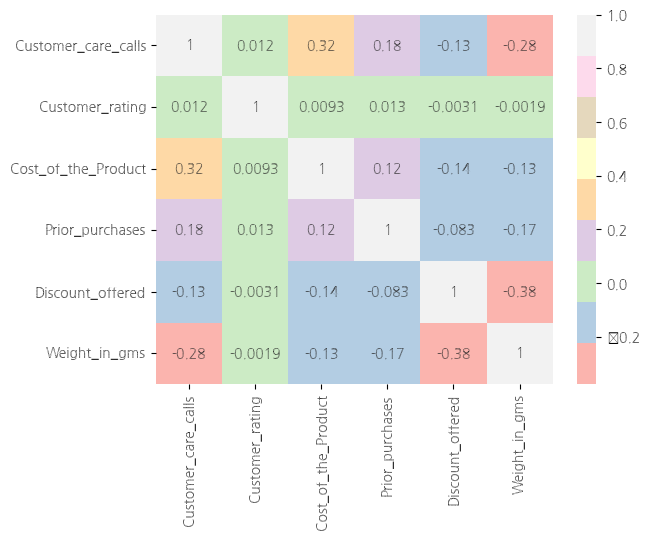

In [40]:
sns.heatmap(train_num.corr(), annot=True, cmap='Pastel1')

2) 범주형 Feature
- 데이터 확인

> 데이터 확인

In [41]:
train_cat_dummies.nunique().sort_values()

Warehouse_block_A            2
Warehouse_block_B            2
Warehouse_block_C            2
Warehouse_block_D            2
Warehouse_block_F            2
Mode_of_Shipment_Flight      2
Mode_of_Shipment_Road        2
Mode_of_Shipment_Ship        2
Product_importance_high      2
Product_importance_low       2
Product_importance_medium    2
Gender_F                     2
Gender_M                     2
dtype: int64

In [42]:
train_cat_dummies.head()

,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
0,0,0,0,1,0,1,0,0,0,1,0,1,0
1,0,0,0,0,1,1,0,0,0,1,0,0,1
2,1,0,0,0,0,1,0,0,0,1,0,0,1
3,0,1,0,0,0,1,0,0,0,0,1,0,1
4,0,0,1,0,0,1,0,0,0,0,1,1,0


In [43]:
from scipy.stats import chi2_contingency
import numpy as np

# 숫자형 피쳐는 유사도 확인에 Pearson R을 많이 사용하고 범주형 피쳐는 Cramers V를 많이 사용

def cramers_V(var1, var2):
  crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
  stat = chi2_contingency(crosstab)[0]
  obs = np.sum(crosstab)
  mini = min(crosstab.shape) - 1
  return (stat/(obs*mini))

In [44]:
rows = []

for var1 in train_cat_dummies:
  col = []
  for var2 in train_cat_dummies:
    cramers = cramers_V(train_cat_dummies[var1], train_cat_dummies[var2])
    col.append(round(cramers, 2))
  rows.append(col)

cramers_result = np.array(rows)
df = pd.DataFrame(cramers_result, columns=train_cat_dummies.columns, index=train_cat_dummies.columns)

In [45]:
df

,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
Warehouse_block_A,1.00,0.04,0.04,0.04,0.1,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Warehouse_block_B,0.04,1.00,0.04,0.04,0.1,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Warehouse_block_C,0.04,0.04,1.00,0.04,0.1,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Warehouse_block_D,0.04,0.04,0.04,1.00,0.1,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Warehouse_block_F,0.10,0.10,0.10,0.10,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Mode_of_Shipment_Flight,0.00,0.00,0.00,0.00,0.0,1.00,0.04,0.41,0.00,0.00,0.00,0.0,0.0
Mode_of_Shipment_Road,0.00,0.00,0.00,0.00,0.0,0.04,1.00,0.40,0.00,0.00,0.00,0.0,0.0
Mode_of_Shipment_Ship,0.00,0.00,0.00,0.00,0.0,0.41,0.40,1.00,0.00,0.00,0.00,0.0,0.0
Product_importance_high,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1.00,0.09,0.07,0.0,0.0
Product_importance_low,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.09,1.00,0.71,0.0,0.0


In [46]:
np.sum(df > 0.9)
# Gender에 높은 상관계수가 본인을 제외하고도 하나 더 있다고 나오는 이유는 F가 아니면 M이고 M이 아니면 F이기 때문이므로 제거할 상관계수는 없음

Warehouse_block_A            1
Warehouse_block_B            1
Warehouse_block_C            1
Warehouse_block_D            1
Warehouse_block_F            1
Mode_of_Shipment_Flight      1
Mode_of_Shipment_Road        1
Mode_of_Shipment_Ship        1
Product_importance_high      1
Product_importance_low       1
Product_importance_medium    1
Gender_F                     2
Gender_M                     2
dtype: int64

최종 학습 데이터 생성

In [47]:
train_final = pd.concat([train["Reached_on_Time_Y_N"], train_num, train_cat_dummies], axis=1)

In [48]:
train_final.head()

,Reached_on_Time_Y_N,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
0,1,4,2,177,3,44,1233,0,0,0,1,0,1,0,0,0,1,0,1,0
1,1,4,5,216,2,59,3088,0,0,0,0,1,1,0,0,0,1,0,0,1
2,1,2,2,183,4,48,3374,1,0,0,0,0,1,0,0,0,1,0,0,1
3,1,3,3,176,4,10,1177,0,1,0,0,0,1,0,0,0,0,1,0,1
4,1,2,2,184,3,46,2484,0,0,1,0,0,1,0,0,0,0,1,1,0


In [49]:
target = train["Reached_on_Time_Y_N"]

In [50]:
X = pd.concat([train_num, train_cat_dummies], axis=1)
Y = train["Reached_on_Time_Y_N"]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)

## 예측 분석  
고객 정보를 활용한 정시 배송 예측  

### Logistic Regression.
모델 생성

In [52]:
model = LogisticRegression()
model.fit(X_train, y_train)
lr_predictions = model.predict(X_test)

모델 평가

In [53]:
print(f"Accuracy score: {accuracy_score(y_test, lr_predictions)}")
print("=" * 60)
print(classification_report(y_test, lr_predictions))

Accuracy score: 0.6293939393939394
              precision    recall  f1-score   support

           0       0.55      0.53      0.54      1344
           1       0.68      0.70      0.69      1956

    accuracy                           0.63      3300
   macro avg       0.62      0.61      0.61      3300
weighted avg       0.63      0.63      0.63      3300



RFE(Recursive Feature Elimination) 적용
> 모든 feature들로부터 feature를 하나하나 제거하면서 원하는 개수의 feature가 남을 때까지 이를 반복

In [55]:
# Backward
from sklearn.feature_selection import RFE

rfe = RFE(model, n_features_to_select=6)
X_rfe = rfe.fit_transform(X, Y)
model.fit(X_rfe, Y)

print(rfe.support_)
print(rfe.ranking_)
print(X.columns[rfe.support_])

[False False False  True  True False  True False False False False False
 False False False  True  True False  True]
[12  9 13  1  1 14  1  2  8  4  7 10  6 11  3  1  1  5  1]
Index(['Prior_purchases', 'Discount_offered', 'Warehouse_block_A',
       'Product_importance_low', 'Product_importance_medium', 'Gender_M'],
      dtype='object')


SelectKBest 적용

In [56]:
# Univariate Selection
X_new = SelectKBest(chi2, k=6).fit_transform(X, Y)

In [57]:
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, Y, test_size = 0.30)

In [58]:
model = LogisticRegression()
model.fit(X_new_train, y_new_train)
lr_predictions = model.predict(X_new_test)

In [59]:
print(f"Accuracy score: {accuracy_score(y_new_test, lr_predictions)}")
print("=" * 60)
print(classification_report(y_new_test, lr_predictions))

Accuracy score: 0.63
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      1350
           1       0.69      0.67      0.68      1950

    accuracy                           0.63      3300
   macro avg       0.62      0.62      0.62      3300
weighted avg       0.63      0.63      0.63      3300



### SVM

Feature Scaling

In [60]:
sc_x = StandardScaler()
X_train_sc = sc_x.fit_transform(X_train)
X_test_sc = sc_x.transform(X_test)

모델 생성

In [62]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train_sc, y_train)
clf_predictions = clf.predict(X_test_sc)

모델 평가

In [63]:
print(f"Accuracy score: {accuracy_score(y_test, clf_predictions.round(), normalize=True)}")
print("=" * 60)
print(classification_report(y_test, clf_predictions))

Accuracy score: 0.6618181818181819
              precision    recall  f1-score   support

           0       0.57      0.71      0.63      1344
           1       0.76      0.63      0.69      1956

    accuracy                           0.66      3300
   macro avg       0.66      0.67      0.66      3300
weighted avg       0.68      0.66      0.66      3300



SelectKBest 적용 후 평기

In [64]:
# MinMax Scaling 적용
X_norm = MinMaxScaler().fit_transform(X)

# SelectKBest 적용
X_new = SelectKBest(chi2, k=6).fit_transform(X_norm, Y)

X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, Y, test_size = 0.30)

clf = svm.SVC(kernel='linear')
clf.fit(X_new_train, y_new_train)
clf_predictions = clf.predict(X_new_test)

print(f"Accuracy score: {accuracy_score(y_new_test, clf_predictions.round(), normalize=True)}")
print("=" * 60)
print(classification_report(y_new_test, clf_predictions))

Accuracy score: 0.6681818181818182
              precision    recall  f1-score   support

           0       0.59      0.71      0.64      1403
           1       0.75      0.64      0.69      1897

    accuracy                           0.67      3300
   macro avg       0.67      0.67      0.67      3300
weighted avg       0.68      0.67      0.67      3300



### RandomForest

모델 생성

In [65]:
rf = RandomForestRegressor(n_estimators=20, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [66]:
print(f"Accuracy score: {accuracy_score(y_test, y_pred.round())}")

Accuracy score: 0.6539393939393939


Feature Importance

<Axes: xlabel='Importance', ylabel='Feature'>

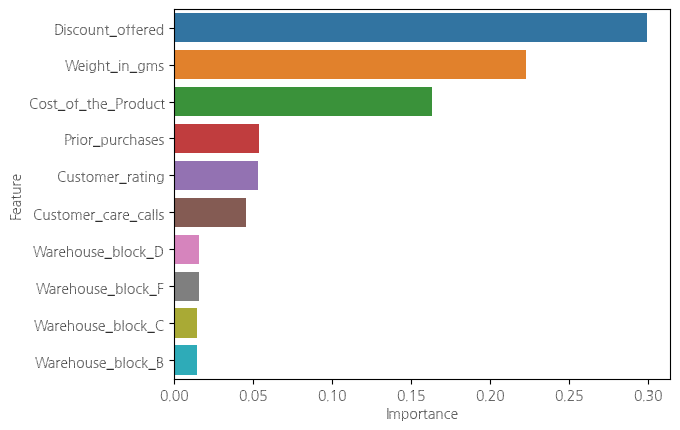

In [67]:
feat = X.columns.values
imp = rf.feature_importances_
df = pd.DataFrame({'Feature': feat, 'Importance': imp})
df = df.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=df)

In [70]:
trace = go.Scatter(
    y=rf.feature_importances_,
    x=X.columns.values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=13,
        color=rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text=X.columns.values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='Random Forest Feature Importance',
    hovermode='closest',
    xaxis=dict(
        ticklen=5,
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title='Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

RFE(Recursive Feature Elimination) 적용

In [71]:
rfe = RFE(rf, n_features_to_select=6)
X_rfe = rfe.fit_transform(X, Y)
rf.fit(X_rfe, Y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True False False False False False False
 False False False False False False False]
[ 1  1  1  1  1  1  8  7  6 10  4 11 12  5 14  3  9  2 13]


SelectKBest 적용 후 평가

In [72]:
X_new = SelectKBest(chi2, k=6).fit_transform(X, Y)

X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, Y, test_size=0.30)

rf = RandomForestRegressor(n_estimators=30, random_state=0)
rf.fit(X_new_train, y_new_train)
y_pred = rf.predict(X_new_test)

print(f"Accuracy score: {accuracy_score(y_new_test, y_pred.round())}")

Accuracy score: 0.6687878787878788


### XGBoost

모델 생성

In [73]:
xgmodel = XGBClassifier()
xgmodel.fit(X_train, y_train)
y_pred = xgmodel.predict(X_test)

In [74]:
print(f"Accuracy score: {accuracy_score(y_test, y_pred.round())}")

Accuracy score: 0.6484848484848484


RFE(Recursive Feature Elimination) 적용

In [75]:
rfe = RFE(xgmodel, n_features_to_select=6)
X_rfe = rfe.fit_transform(X, Y)
xgmodel.fit(X_rfe, Y)
print(rfe.support_)
print(rfe.ranking_)

[False False  True  True  True  True  True False False False False False
  True False False False False False False]
[ 5  8  1  1  1  1  1  6  3  7  4  2  1 10 11 12 13  9 14]


In [76]:
X_new = SelectKBest(chi2, k=6).fit_transform(X, Y)

X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, Y, test_size=0.30)

xgmodel = XGBClassifier()
xgmodel.fit(X_new_train, y_new_train)
y_pred = xgmodel.predict(X_new_test)

print(f"Accuracy score: {accuracy_score(y_new_test, y_pred.round())}")

Accuracy score: 0.6433333333333333
